# Receive Renovar API Data

## Constants and imports

### Imports

In [1]:
from SensorData import SensorData
from GetSensorDataService import GetSensorDataService
from SensorDataAnalysisService import SensorDataAnalysisService as sensor_analysis

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Sensors IDs

In [2]:
TEMPERATURE_ID     =  130
PRESSURE_ID        =  131
ALPHA_CO_ID        =  132
ALPHA_NO2_ID       =  133
ALPHA_SO2_1_ID     =  134
ALPHA_OX_1_ID      =  135
ALPHA_OX_2_ID      =  136
ALPHA_SO2_2_ID     =  137
EXT_TEMPERATURE_ID =  138
EXT_HUMIDITY_ID    =  139
PM10_ID            =  140
PM25_ID            =  141
PM01_ID            =  142
OPC_TEMPERATURE_ID =  143
OPC_HUMIDITY_ID    =  144

### API Constants

In [3]:
HOST = "renovar.lcqar.ufsc.br"
PORT = 8080
GET_SAMPLES_BY_SENSOR = "/sample/sensor/all/"
HTTP_REQUEST_MAIN = 'http://' + HOST + ':' + str(PORT) + GET_SAMPLES_BY_SENSOR

# Alphasense CO Sensor Data

In [4]:
get_sensor_data_service = GetSensorDataService(HOST, PORT, GET_SAMPLES_BY_SENSOR)
sensor_data = get_sensor_data_service.get_data_from_file("data/raw-data-monit-fix-2022-2023-Diamante/ISB_CO.CSV",
                                                         sensor_name='alpha_co_conc')
sensor_data.head()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/GetSensorDataService.py:15: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['DateTime'] = (pd.to_datetime(df[date_time_col], infer_datetime_format=False, format='%d/%m/%Y/%H/%M/%S'))


,latitude,longitude,measuring,DateTime
0,-28.456899,-48.972999,125.92,2022-11-20 13:45:23
1,-28.456899,-48.972999,86.05,2022-11-21 10:37:45
2,-28.456899,-48.972999,86.38,2022-11-21 10:53:33
3,-28.456899,-48.972999,96.05,2022-11-21 11:09:20
4,-28.456899,-48.972999,84.43,2022-11-21 11:25:07


In [5]:
alpha_co_conc_data = SensorData(ALPHA_CO_ID, sensor_name='alpha_co_conc', lower_limit=4.0, upper_limit=1e6, 
                                t_90=30, t_90_value=10e3, sampling_period=15 * 60, 
                                get_service=get_sensor_data_service)

## Upload Data from File

In [6]:
alpha_co_conc_data.read_from_csv()
alpha_co_conc_data.web_dataframe.head()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/SensorData.py:128: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  self.web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))


,latitude,longitude,measuring,DateTime
0,-28.456899,-48.972999,125.92,2022-11-20 13:45:23
1,-28.456899,-48.972999,86.05,2022-11-21 10:37:45
2,-28.456899,-48.972999,86.38,2022-11-21 10:53:33
3,-28.456899,-48.972999,96.05,2022-11-21 11:09:20
4,-28.456899,-48.972999,84.43,2022-11-21 11:25:07


## Tag data

In [7]:
alpha_co_conc_data.tag_and_prepare_data()
alpha_co_conc_data.sensor_dataframe.head()

,latitude,longitude,measuring,Tag,Diff
DateTime,,,,,
2022-11-20 13:45:00,-28.456899,-48.972999,125.92,VALID,NaN
2022-11-20 14:00:00,NaN,NaN,NaN,MISSING,NaN
2022-11-20 14:15:00,NaN,NaN,NaN,MISSING,NaN
2022-11-20 14:30:00,NaN,NaN,NaN,MISSING,NaN
2022-11-20 14:45:00,NaN,NaN,NaN,MISSING,NaN


### Data Tag contabilization

In [8]:
tags = ['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID']
data_contabilization = sensor_analysis.count_tags(tags, alpha_co_conc_data.sensor_dataframe)
data_contabilization

,#,%
MISSING,6027,34.153114
LTLL,1582,8.964697
GTUL,0,0.0
BADSPIKE,0,0.0
VALID,10038,56.88219
TOTAL,17647,100.0


### Plot raw data

<Axes: xlabel='DateTime'>

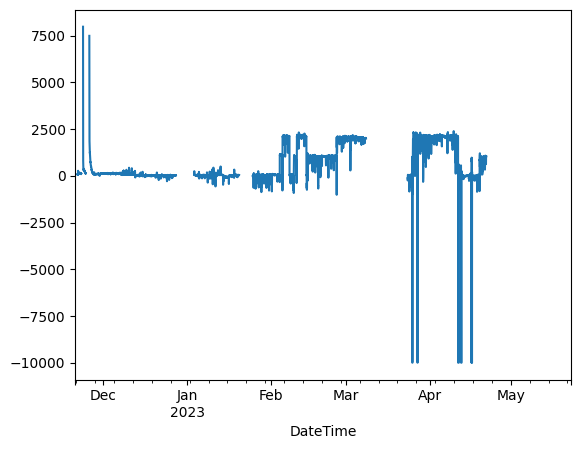

In [9]:
alpha_co_conc_data.sensor_dataframe['measuring'].plot()

### Plot Valid Data

<Axes: xlabel='DateTime'>

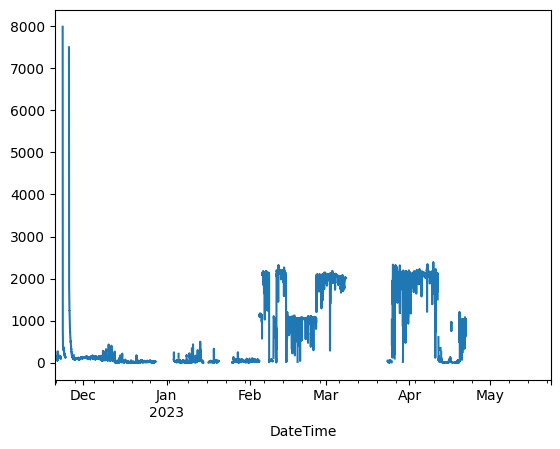

In [10]:
alpha_co_conc_data.sensor_dataframe[alpha_co_conc_data.sensor_dataframe['Tag'] == 'VALID']['measuring'].resample('15T').mean().plot()

### Plot raw derivatives

<Axes: xlabel='DateTime'>

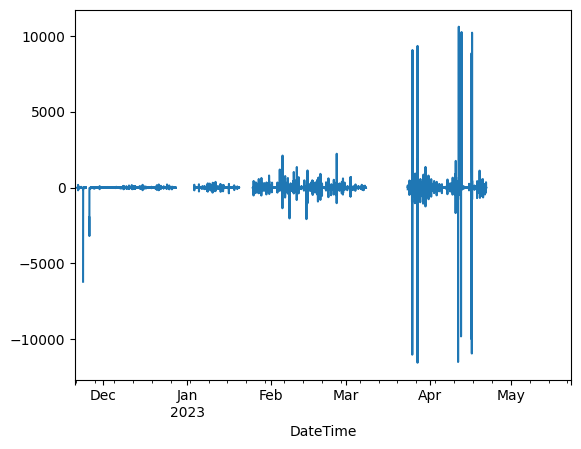

In [11]:
alpha_co_conc_data.sensor_dataframe['Diff'].resample('15T').mean().plot()

### Plot valid derivatives

<Axes: xlabel='DateTime'>

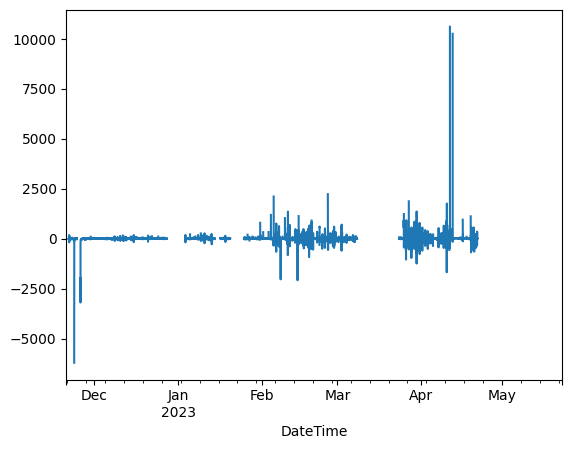

In [12]:
alpha_co_conc_data.valid_differential_series.resample('15T').mean().plot()

## Resampled data

In [13]:
alpha_co_conc_data.sensor_dataframe_1hr.head()

,latitude,longitude,measuring,Diff,Hour,Count,Std,% valid,Tag
DateTime,,,,,,,,,
2022-11-20 13:00:00,-28.456899,-48.972999,125.92,NaN,13,1,NaN,25.0,LOWSAMPLES
2022-11-20 14:00:00,NaN,NaN,NaN,NaN,14,0,NaN,0.0,LOWSAMPLES
2022-11-20 15:00:00,NaN,NaN,NaN,NaN,15,0,NaN,0.0,LOWSAMPLES
2022-11-20 16:00:00,NaN,NaN,NaN,NaN,16,0,NaN,0.0,LOWSAMPLES
2022-11-20 17:00:00,NaN,NaN,NaN,NaN,17,0,NaN,0.0,LOWSAMPLES


### Data contabilization

In [14]:
tags = ['LOWSAMPLES','VALID'] 
data_contabilization = sensor_analysis.count_tags(tags, alpha_co_conc_data.sensor_dataframe_1hr)
data_contabilization

,#,%
LOWSAMPLES,1923,43.575799
VALID,2490,56.424201
TOTAL,4413,100.0


### Plot raw hourly data

<Axes: xlabel='DateTime'>

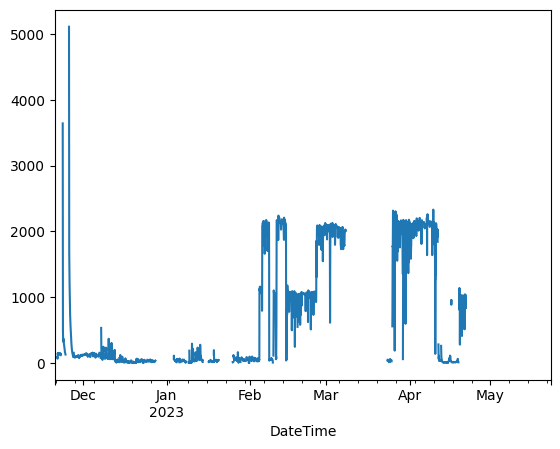

In [15]:
alpha_co_conc_data.sensor_dataframe_1hr['measuring'].plot()

### Plot valid hourly data

<Axes: xlabel='DateTime'>

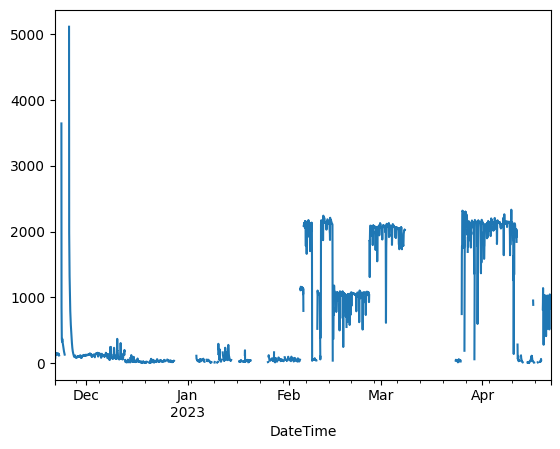

In [16]:
alpha_co_conc_data.sensor_dataframe_1hr[alpha_co_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID']['measuring'].resample('H').mean().plot()

### Plot raw standard deviation

<Axes: xlabel='DateTime'>

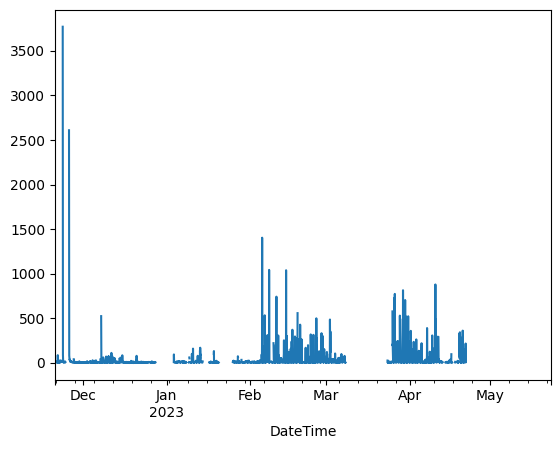

In [17]:
alpha_co_conc_data.sensor_dataframe_1hr['Std'].resample('H').mean().plot()

### Plot valid standard deviation

<Axes: xlabel='DateTime'>

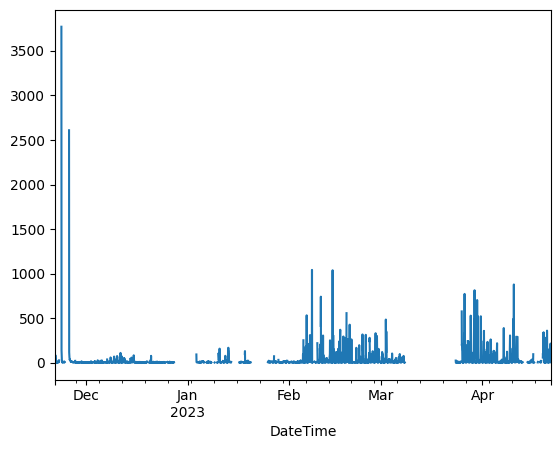

In [18]:
alpha_co_conc_data.sensor_dataframe_1hr[alpha_co_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID']['Std'].resample('H').mean().plot()

## Calculate quantiles and tag data accordingly

### Calculate quantiles

In [19]:
alpha_co_conc_data.calculate_and_tag_quantiles()
alpha_co_conc_data.sensor_dataframe_1hr.head()

,latitude,longitude,measuring,Diff,Hour,Count,Std,% valid,Tag,GLOBAL_QTLE01,GLOBAL_QTLE99
DateTime,,,,,,,,,,,
2022-11-20 13:00:00,-28.456899,-48.972999,125.92,NaN,13,1,NaN,25.0,LOWSAMPLES,11.352500,2172.4600
2022-11-20 14:00:00,NaN,NaN,NaN,NaN,14,0,NaN,0.0,LOWSAMPLES,10.832500,2171.6100
2022-11-20 15:00:00,NaN,NaN,NaN,NaN,15,0,NaN,0.0,LOWSAMPLES,12.307500,2177.6800
2022-11-20 16:00:00,NaN,NaN,NaN,NaN,16,0,NaN,0.0,LOWSAMPLES,6.156667,2262.8825
2022-11-20 17:00:00,NaN,NaN,NaN,NaN,17,0,NaN,0.0,LOWSAMPLES,10.777500,2203.8625


In [20]:
tags = ['LOWSAMPLES','VALID', 'LTQTLE01', 'GTQTLE99']
data_contabilization = sensor_analysis.count_tags(tags, alpha_co_conc_data.sensor_dataframe_1hr)
data_contabilization

,#,%
LOWSAMPLES,1923,43.575799
VALID,2412,54.656696
LTQTLE01,39,0.883753
GTQTLE99,39,0.883753
TOTAL,4413,100.0


## Process valid hourly data

In [21]:
valid_dataframe = (alpha_co_conc_data.sensor_dataframe_1hr[alpha_co_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID']
                   .drop(columns=['Tag']).resample('H').mean())

### Plot mean vs. standard deviation for valid hourly data colored by valid percentage of valid samples

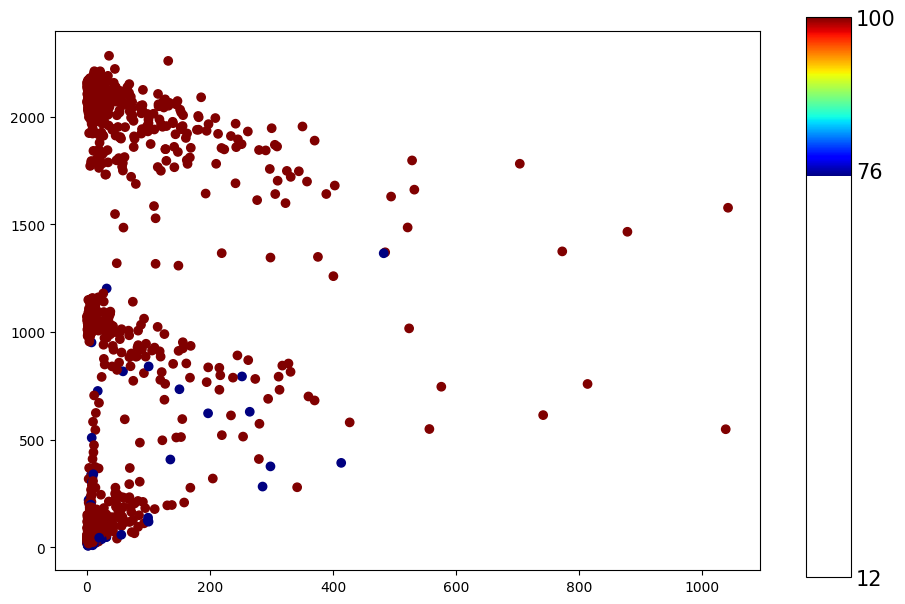

In [22]:
sensor_analysis.plot_mean_vs_std(valid_dataframe)

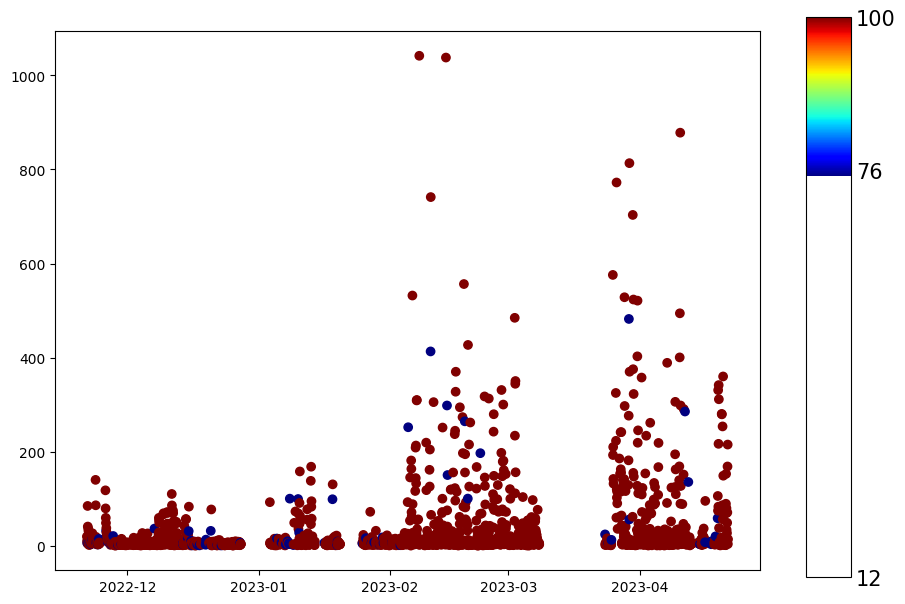

In [23]:
sensor_analysis.plot_std_in_time(valid_dataframe)

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/SensorDataAnalysisService.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


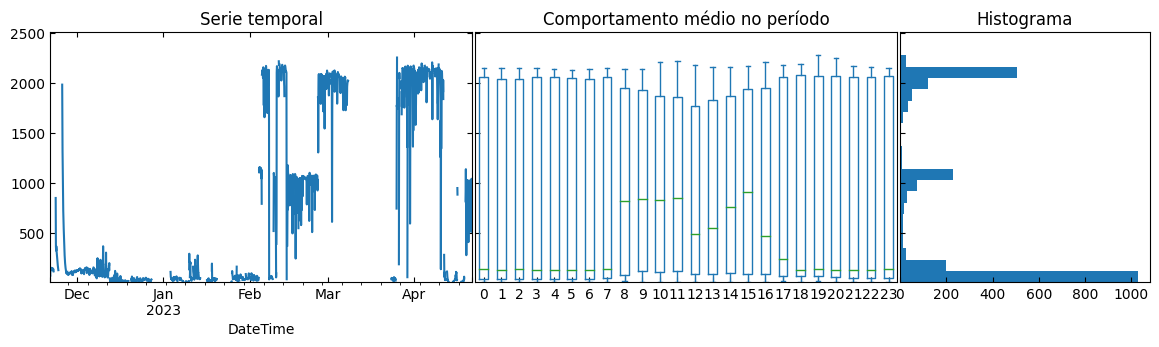

In [24]:
sensor_analysis.plot_box_hist(valid_dataframe, 20)

## Save Data

In [25]:
alpha_co_conc_data.save_to_csv()